In [ ]:
!pip install kaggle

In [ ]:
import seaborn as sns
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


In [ ]:

# Load the metadata file
metadata_path = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

# Preview the data
print(metadata_df.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


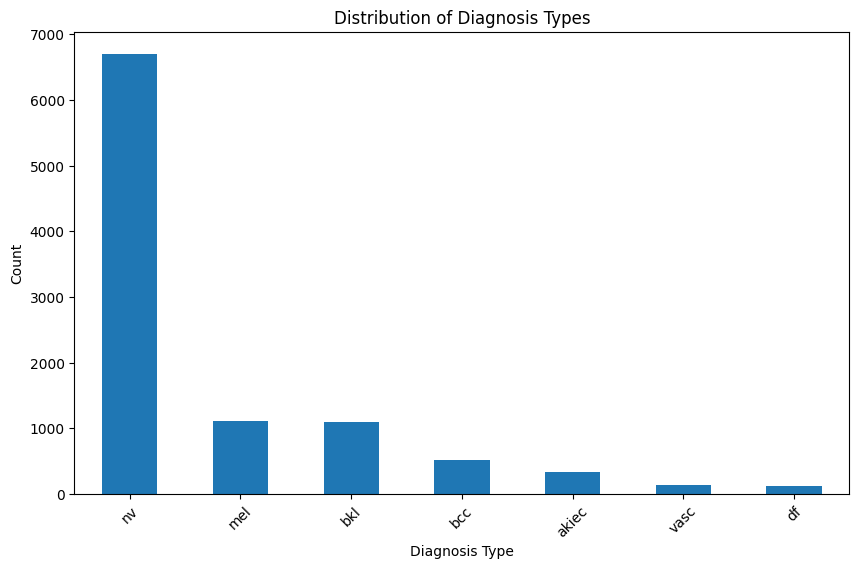

In [ ]:
# Diagnosis type distribution
dx_counts = metadata_df['dx'].value_counts()
plt.figure(figsize=(10, 6))
dx_counts.plot(kind='bar')
plt.title('Distribution of Diagnosis Types')
plt.xlabel('Diagnosis Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

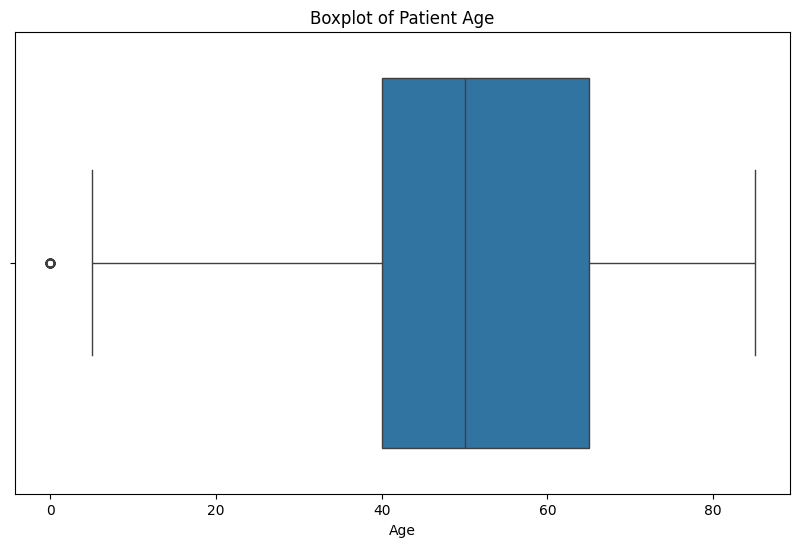

In [ ]:
# Boxplot for Age Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=metadata_df['age'])
plt.title('Boxplot of Patient Age')
plt.xlabel('Age')
plt.show()

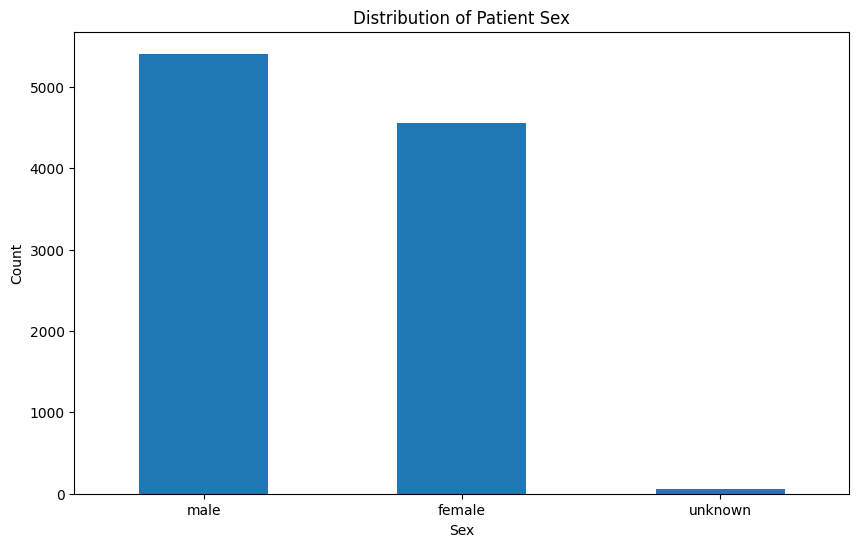

In [ ]:
# Sex distribution
sex_counts = metadata_df['sex'].value_counts()
plt.figure(figsize=(10, 6))
sex_counts.plot(kind='bar')
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

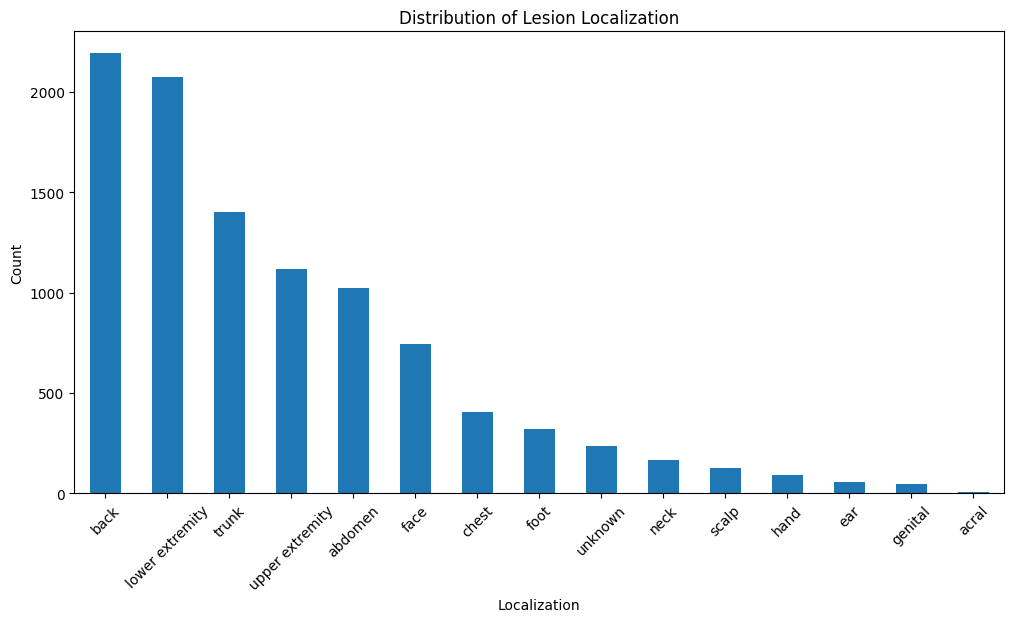

In [ ]:
# Lesion localization distribution
localization_counts = metadata_df['localization'].value_counts()
plt.figure(figsize=(12, 6))
localization_counts.plot(kind='bar')
plt.title('Distribution of Lesion Localization')
plt.xlabel('Localization')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Summary of missing values for each column
missing_summary = metadata_df[['age', 'sex', 'localization']].isna().sum()

# Percentage of missing values
missing_percentage = (missing_summary / len(metadata_df)) * 100

print("Missing Values Summary:")
print(pd.DataFrame({'Missing Count': missing_summary, 'Percentage': missing_percentage}))


Missing Values Summary:
              Missing Count  Percentage
age                      57    0.569146
sex                       0    0.000000
localization              0    0.000000


In [ ]:
# Replace missing age with median age
metadata_df['age'] = metadata_df['age'].fillna(metadata_df['age'].median())


In [ ]:
# Records with any missing value
missing_data = metadata_df[metadata_df[['age', 'sex', 'localization']].isna().any(axis=1)]
print(f"Number of records with missing values: {len(missing_data)}")

Number of records with missing values: 0


In [ ]:
# Get unique classes and their counts
classes = metadata_df['dx'].unique()

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=metadata_df['dx']
)

# Convert to dictionary for easy use
class_weight_dict = dict(zip(classes, class_weights))
print(f"Class Weights: {class_weight_dict}")

Class Weights: {'bkl': 1.301832835044846, 'nv': 0.21338020666879728, 'df': 12.440993788819876, 'mel': 1.2854575792581184, 'vasc': 10.075452716297788, 'bcc': 2.78349082823791, 'akiec': 4.375273044997815}


In [ ]:
import os

# Define the paths to the two folders
folder1 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1"
folder2 = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2"

# Function to determine the full path of an image
def get_image_path(image_id):
    if os.path.exists(os.path.join(folder1, f"{image_id}.jpg")):
        return os.path.join(folder1, f"{image_id}.jpg")
    elif os.path.exists(os.path.join(folder2, f"{image_id}.jpg")):
        return os.path.join(folder2, f"{image_id}.jpg")
    else:
        return None

# Add the full image path to the metadata DataFrame
metadata_df['image_path'] = metadata_df['image_id'].apply(get_image_path)

# Verify
print(metadata_df[['image_id', 'image_path']].head())


       image_id                                         image_path
0  ISIC_0027419  /root/.cache/kagglehub/datasets/kmader/skin-ca...
1  ISIC_0025030  /root/.cache/kagglehub/datasets/kmader/skin-ca...
2  ISIC_0026769  /root/.cache/kagglehub/datasets/kmader/skin-ca...
3  ISIC_0025661  /root/.cache/kagglehub/datasets/kmader/skin-ca...
4  ISIC_0031633  /root/.cache/kagglehub/datasets/kmader/skin-ca...


In [ ]:
from sklearn.preprocessing import LabelEncoder
import os

# Assign numerical values to dx
dx_encoder = LabelEncoder()
metadata_df['dx_num'] = dx_encoder.fit_transform(metadata_df['dx'])

# Assign numerical values to localization
localization_encoder = LabelEncoder()
metadata_df['localization_num'] = localization_encoder.fit_transform(metadata_df['localization'])

# Check the mappings
print("dx mapping:", dict(zip(dx_encoder.classes_, dx_encoder.transform(dx_encoder.classes_))))
print("localization mapping:", dict(zip(localization_encoder.classes_, localization_encoder.transform(localization_encoder.classes_))))


dx mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
localization mapping: {'abdomen': 0, 'acral': 1, 'back': 2, 'chest': 3, 'ear': 4, 'face': 5, 'foot': 6, 'genital': 7, 'hand': 8, 'lower extremity': 9, 'neck': 10, 'scalp': 11, 'trunk': 12, 'unknown': 13, 'upper extremity': 14}


In [ ]:
# Map 'sex' to numerical values
def encode_sex(sex):
    if sex.lower() == 'male':
        return 0
    elif sex.lower() == 'female':
        return 1
    else:  # For 'unknown' or other values
        return 2

# Apply encoding
metadata_df['sex_num'] = metadata_df['sex'].apply(encode_sex)

# Check the unique values and their mappings
print("Sex mapping: Male -> 0, Female -> 1, Unknown -> 2")
print(metadata_df[['sex', 'sex_num']].drop_duplicates())


Sex mapping: Male -> 0, Female -> 1, Unknown -> 2
         sex  sex_num
0       male        0
8     female        1
968  unknown        2


In [ ]:
metadata_df.to_csv('processed_metadata.csv', index=False)

In [ ]:

# Example class distribution
class_counts = metadata_df['dx'].value_counts()
print("Class distribution before undersampling:")
print(class_counts)

# Calculate the target size for the 'nv' class
mel_count = class_counts['mel']
other_count = class_counts.drop(['nv', 'mel']).sum()

# Option 1: Complete balance (match the smallest class)
target_nv_size = min(mel_count, other_count)

# Option 2: Relative balance (average of other classes)
# target_nv_size = (mel_count + other_count) // 2

print(f"Target 'nv' size: {target_nv_size}")

# Separate the classes
nv_samples = metadata_df[metadata_df['dx'] == 'nv']
mel_samples = metadata_df[metadata_df['dx'] == 'mel']
other_samples = metadata_df[(metadata_df['dx'] != 'nv') & (metadata_df['dx'] != 'mel')]

# Undersample 'nv' class
undersampled_nv = nv_samples.sample(n=target_nv_size, random_state=42)

# Combine the datasets
balanced_dataset = pd.concat([undersampled_nv, mel_samples, other_samples])

# Shuffle the dataset
balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
print("Class distribution after undersampling:")
print(balanced_dataset['dx'].value_counts())


Class distribution before undersampling:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64
Target 'nv' size: 1113
Class distribution after undersampling:
dx
mel      1113
nv       1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:

from sklearn.model_selection import train_test_split

# Split into train_val and test sets
train_val_df, test_df = train_test_split(
    balanced_dataset, test_size=0.2, stratify=balanced_dataset['dx_num'], random_state=42
)

# Split train_val into training and validation sets
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, stratify=train_val_df['dx_num'], random_state=42
)

print("Training set size:", train_df.shape)
print("Validation set size:", val_df.shape)
print("Test set size:", val_df.shape)





Training set size: (2830, 11)
Validation set size: (708, 11)
Test set size: (708, 11)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Concatenate, Flatten, BatchNormalization
)
from tensorflow.keras.utils import to_categorical


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),  # Replace with your target column
    y=train_df['dx']
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



Class Weights: {0: 1.9343814080656185, 1: 1.228831958315241, 2: 0.5750863645600488, 3: 5.463320463320463, 4: 0.5678170144462279, 5: 0.5678170144462279, 6: 4.442700156985871}


In [ ]:
# Extract tabular features
train_tabular = train_df[['age', 'sex_num', 'localization_num']].values
val_tabular = val_df[['age', 'sex_num', 'localization_num']].values
test_tabular = test_df[['age', 'sex_num', 'localization_num']].values


# Extract labels (dx_num) for training and validation
train_labels = train_df['dx_num'].values
val_labels = val_df['dx_num'].values
test_labels = test_df['dx_num'].values


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)  # Size expected by EfficientNet

def preprocess_dataset(image_paths, tabular_features, labels, batch_size=16, is_training=True):
    # Image preprocessing function
    @tf.function
    def preprocess_data(image_path, tabular, label):
        # Load and preprocess the image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return (img, tabular), label

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tabular_features, labels))
    dataset = dataset.map(
        lambda image_path, tabular, label: preprocess_data(image_path, tabular, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)  # Shuffle during training

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Batch and prefetch for performance
    return dataset


In [ ]:
'''train_dataset = preprocess_dataset(train_df['image_path'], train_tabular, train_labels, batch_size=4, is_training=True)
val_dataset = preprocess_dataset(val_df['image_path'], val_tabular, val_labels, batch_size=4, is_training=False)
test_dataset = preprocess_dataset(test_df['image_path'], test_tabular, test_labels, batch_size=4, is_training=False)'''

"train_dataset = preprocess_dataset(train_df['image_path'], train_tabular, train_labels, batch_size=4, is_training=True)\nval_dataset = preprocess_dataset(val_df['image_path'], val_tabular, val_labels, batch_size=4, is_training=False)\ntest_dataset = preprocess_dataset(test_df['image_path'], test_tabular, test_labels, batch_size=4, is_training=False)"

In [ ]:
train_dataset = preprocess_dataset(
    train_df['image_path'].values,
    train_tabular,
    train_labels,
    batch_size=16,
    is_training=True
)

val_dataset = preprocess_dataset(
    val_df['image_path'].values,
    val_tabular,
    val_labels,
    batch_size=16,
    is_training=False
)

test_dataset = preprocess_dataset(
    test_df['image_path'].values,
    test_tabular,
    test_labels,
    batch_size=16,
    is_training=False
)


In [ ]:
from tensorflow.keras.regularizers import l2

# EfficientNet for images
image_input = Input(shape=(224, 224, 3), name="image_input")
efficient_net = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=image_input)
x = Flatten()(efficient_net.output)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
image_model_output = Dense(128, activation="relu")(x)

# Tabular data model
tabular_input = Input(shape=(train_tabular.shape[1],), name="tabular_input")
y = Dense(64, activation="relu")(tabular_input)
y = Dropout(0.3)(y)
y = Dense(32, activation="relu")(y)
tabular_model_output = Dense(16, activation="relu")(y)

# Combine the models
combined = Concatenate()([image_model_output, tabular_model_output])
z = Dense(128, activation="relu")(combined)
z = Dropout(0.5)(z)
z = Dense(64, activation="relu")(z)
z = Dense(len(np.unique(train_labels)), activation="softmax")(z)

# Final model
model = Model(inputs=[image_input, tabular_input], outputs=z)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.9343814080656185, 1: 1.228831958315241, 2: 0.5750863645600488, 3: 5.463320463320463, 4: 0.5678170144462279, 5: 0.5678170144462279, 6: 4.442700156985871}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)


history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 208s 548ms/step - accuracy: 0.1546 - loss: 4.7225 - val_accuracy: 0.1441 - val_loss: 4.3837
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - accuracy: 0.2414 - loss: 4.2048 - val_accuracy: 0.3404 - val_loss: 3.9393
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 44s 139ms/step - accuracy: 0.3339 - loss: 3.7739 - val_accuracy: 0.5028 - val_loss: 3.4314
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.4368 - loss: 3.3597 - val_accuracy: 0.5946 - val_loss: 3.0405
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.5205 - loss: 3.0344 - val_accuracy: 0.6144 - val_loss: 2.8349
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.5609 - loss: 2.7944 - val_accuracy: 0.6441 - val_loss: 2.6091
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.6161 - loss: 2.4759 - val_accuracy: 0.6709 - val_loss: 2.4632
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.6811 - loss: 

In [ ]:
# Evaluate the model on the validation dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save('combined_model.h5')


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.7316 - loss: 1.6875


Test Accuracy: 72.88%


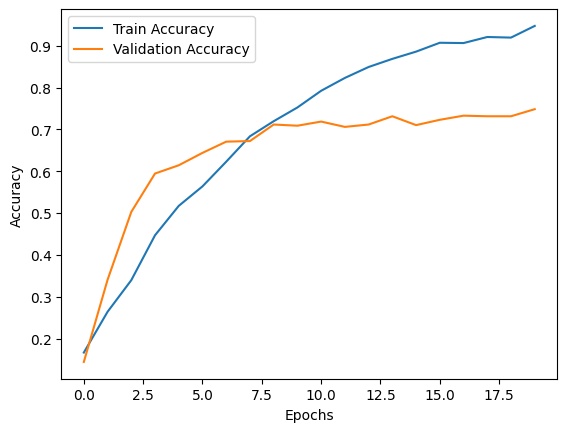

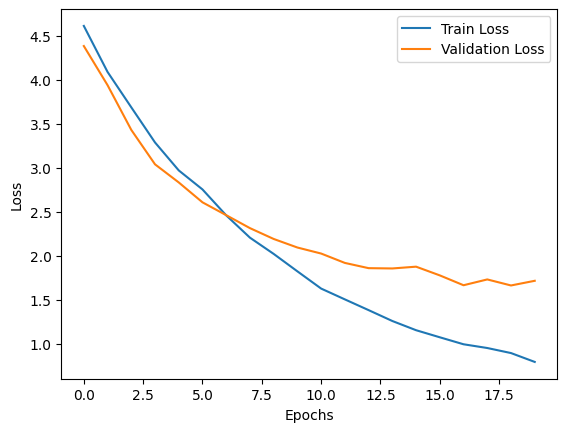

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
